In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
from scipy.spatial import distance as scipy_distance

In [2]:

def find_circles_adaptive(current_frame_gray, num_of_rafts, radii_hough,
                          adaptive_thres_blocksize=9, adaptive_thres_const=-20,
                          min_sep_dist=20, raft_center_threshold=60,
                          top_left_x=390, top_left_y=450, width_x=850, height_y=850):
    """
    find the centers of each raft
    :param current_frame_gray:
    :param num_of_rafts:
    :param radii_hough:
    :param adaptive_thres_blocksize:
    :param adaptive_thres_const:
    :param min_sep_dist:
    :param raft_center_threshold:
    :param top_left_x:
    :param top_left_y:
    :param width_x:
    :param height_y:
    :return: raft_centers, raft_radii, raft_count

    """
    # key data set initialization
    raft_centers = np.zeros((num_of_rafts, 2), dtype=int)
    raft_radii = np.zeros(num_of_rafts, dtype=int)
    
    # crop the image
    image_cropped = current_frame_gray[top_left_y: top_left_y + height_y, top_left_x: top_left_x + width_x]

    # threshold the image
    image_thres = cv.adaptiveThreshold(image_cropped, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,
                                       adaptive_thres_blocksize, adaptive_thres_const)
    plt.imshow(image_thres, cmap='gray')
    # use Hough transform to find circles
    hough_results = hough_circle(image_thres, np.arange(*radii_hough))
    accums, cx, cy, radii = hough_circle_peaks(hough_results, np.arange(*radii_hough))
    # assuming that the first raft (highest accumulator score) is a good one
    #    raft_centers[0,0] = cx[0]
    #    raft_centers[0,1] = cy[0]
    #    raft_radii[0] = radii[0]
    raft_count = 0  # starting from 1!

    # remove circles that belong to the same raft and circles that happened to be in between rafts
    for accumScore, detected_cx, detected_cy, detected_radius in zip(accums, cx, cy, radii):
        new_raft = 1
        if image_cropped[detected_cy, detected_cx] < raft_center_threshold:
            new_raft = 0
        elif image_cropped[detected_cy - detected_radius // 2: detected_cy + detected_radius // 2,
                           detected_cx - detected_radius // 2:detected_cx + detected_radius // 2].mean() \
                < raft_center_threshold:
            new_raft = 0
        #        elif  (detected_cx - width_x/2)**2 +  (detected_cy - height_y/2)**2 > lookup_radius**2:
        #            new_raft = 0
        else:
            cost_matrix = scipy_distance.cdist(np.array([detected_cx, detected_cy], ndmin=2),
                                               raft_centers[:raft_count, :], 'euclidean')
            if np.any(cost_matrix < min_sep_dist):  # raft still exist
                new_raft = 0
        if new_raft == 1:
            raft_centers[raft_count, 0] = detected_cx
            # note that raft_count starts with 1, also note that cx corresonds to columns number
            raft_centers[raft_count, 1] = detected_cy
            # cy is row number
            raft_radii[raft_count] = detected_radius
            raft_count = raft_count + 1
        if raft_count == num_of_rafts:
            #            error_message = 'all rafts found'
            break

    # convert the xy coordinates of the cropped image into the coordinates of the original image
    raft_centers[:, 0] = raft_centers[:, 0] + top_left_x
    raft_centers[:, 1] = raft_centers[:, 1] + top_left_y

    return raft_centers, raft_radii, raft_count

5
[ 7 10  7 11 14  0  0]
6
[ 8  7 10 11 11 11  0]
6
[ 7 12  7  9  7  9  0]
6
[ 8 18 12 10 11  9  0]
4
[ 7  7 19 11  0  0  0]
5
[ 7  9 12 11  9  0  0]
5
[ 7  7 12 13  7  0  0]
4
[ 9  7 12 13  0  0  0]
6
[ 8  7  7 13 11 13  0]
5
[ 7  7 12 15 10  0  0]


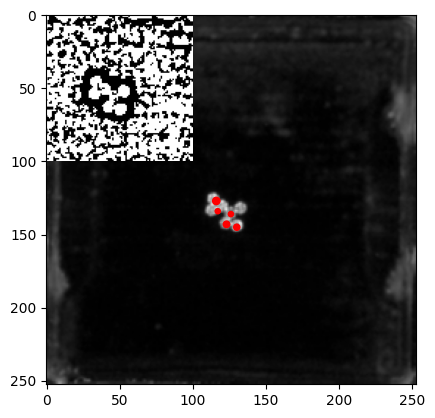

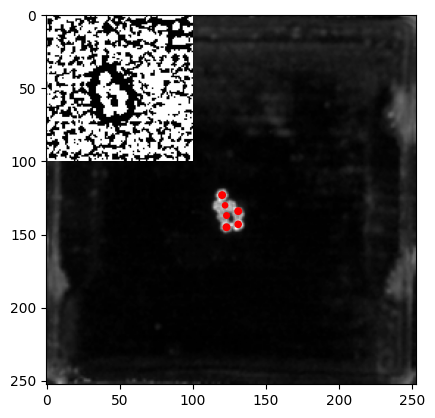

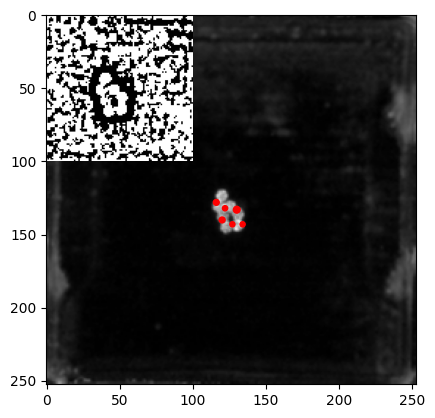

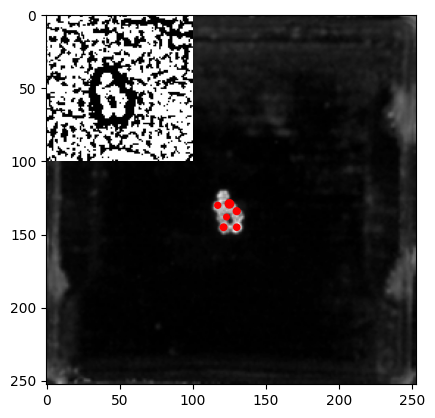

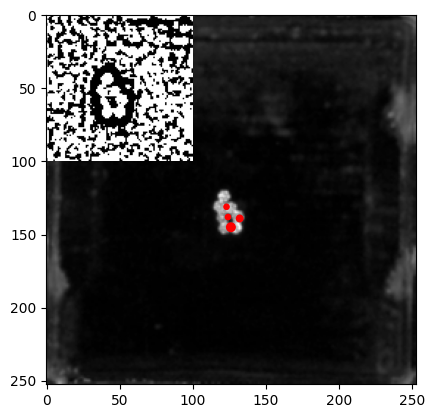

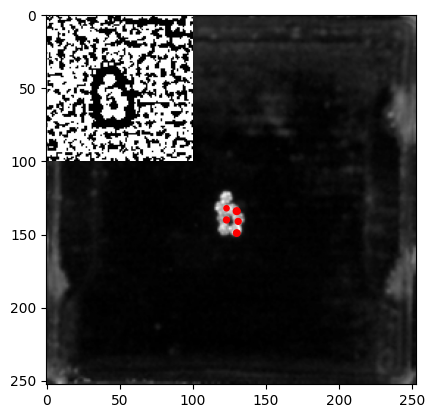

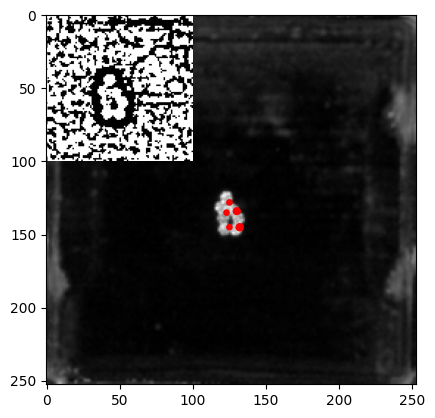

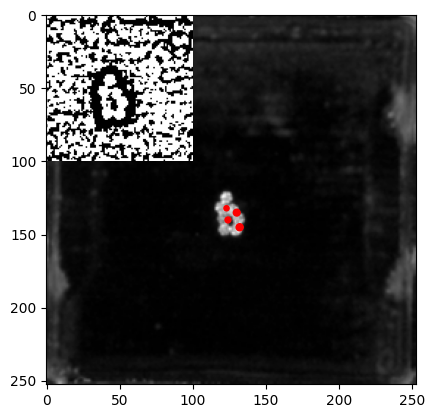

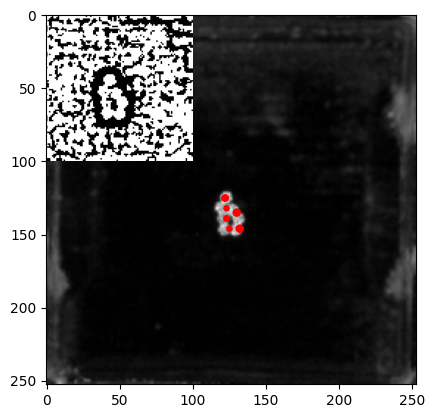

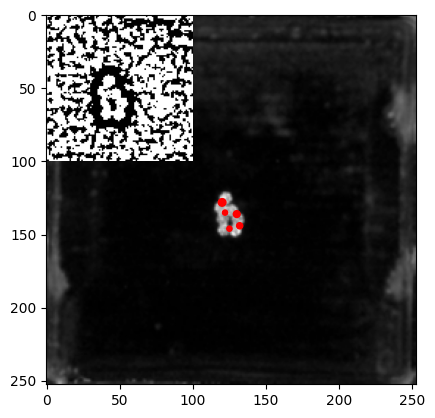

In [74]:
for i in range(10):
    image = cv.imread(f'../images/camera_image_{i:04d}.png')
    # image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = image[:,:,1]
    plt.figure()
    plt.imshow(image, cmap='gray')
    centers, radii, count = find_circles_adaptive(image, 7, [7, 20], top_left_x=80, top_left_y=80, width_x=100, height_y=100, adaptive_thres_blocksize=9, adaptive_thres_const=1, raft_center_threshold=80, min_sep_dist=7)
    print(count)
    print(radii)
    plt.scatter(centers[:, 0], centers[:, 1], c='r', s=radii*2)
    # plt.show()
    